# RAG evaluation

In [ ]:
import json
import os

import nest_asyncio
import pandas as pd
import phoenix as px
from openinference.instrumentation.smolagents import SmolagentsInstrumentor
from phoenix.evals import (
    HALLUCINATION_PROMPT_RAILS_MAP,
    HALLUCINATION_PROMPT_TEMPLATE,
    RAG_RELEVANCY_PROMPT_RAILS_MAP,
    RAG_RELEVANCY_PROMPT_TEMPLATE,
    GeminiModel,
    llm_classify,
)
from phoenix.otel import register
from phoenix.trace import SpanEvaluations, using_project
from phoenix.trace.dsl import SpanQuery
from smolagents import InferenceClientModel, LiteLLMModel, ToolCallingAgent
from tqdm import tqdm

from travel_agent.qdrant import client as qdrant_client
from travel_agent.retrieval.embedding.embedding_generation import MODELS_PROMPTS
from travel_agent.retrieval.smolagents.tool import TravelReviewQueryTool

nest_asyncio.apply()

if not os.getenv("QDRANT_URL"):
    print("Set QDRANT_URL and QDRANT_API_KEY env")
    exit(1)

print(f"Available embed models:\n- {'\n- '.join(MODELS_PROMPTS.keys())}")

Available embed models:
- cointegrated/rubert-tiny2
- DeepPavlov/rubert-base-cased-sentence
- ai-forever/sbert_large_nlu_ru
- ai-forever/sbert_large_mt_nlu_ru
- sentence-transformers/distiluse-base-multilingual-cased-v1
- sentence-transformers/distiluse-base-multilingual-cased-v2
- sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
- sentence-transformers/paraphrase-multilingual-mpnet-base-v2
- intfloat/multilingual-e5-large
- intfloat/multilingual-e5-base
- intfloat/multilingual-e5-small
- ai-forever/ru-en-RoSBERTa
- sergeyzh/BERTA


In [2]:
def local_llm(model_name) -> LiteLLMModel:
    return LiteLLMModel(
        model_id=f"ollama_chat/{model_name}",
        api_base=os.getenv("OLLAMA_URL", "http://127.0.0.1:11434"),
        num_ctx=8192,  # ollama default is 2048 which will fail horribly. 8192 works for easy tasks, more is better. Check https://huggingface.co/spaces/NyxKrage/LLM-Model-VRAM-Calculator to calculate how much VRAM this will need for the selected model.
    )


embed_model_name = "intfloat/multilingual-e5-base"
collection_name = "moskva_intfloat_multilingual_e5_base"

review_search_tool = TravelReviewQueryTool(embed_model_name, qdrant_client, collection_name)

2025-05-03 17:15:38.010 | INFO     | travel_agent.retrieval.smolagents.tool:__init__:85 - Using device: mps


In [3]:
saiga_agent = ToolCallingAgent(
    tools=[review_search_tool],
    model=local_llm("hf.co/IlyaGusev/saiga_nemo_12b_gguf:Q4_0"),
    max_steps=10,
)
saiga_agent.run("Привет!")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Привет!                                                                                                         │
│                                                                                                                 │
╰─ LiteLLMModel - ollama_chat/hf.co/IlyaGusev/saiga_nemo_12b_gguf:Q4_0 ───────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': 'Привет!'}                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final answer: Привет!

[Step 1: Duration 5.05 seconds| Input tokens: 1,305 | Output tokens: 19]

'Привет!'

## Set up [Phoenix](https://phoenix.arize.com/) framework to evaluate

https://huggingface.co/blog/smolagents-phoenix

In [4]:
# run in background:
#
# uv run -m phoenix.server.main serve
#
# then run this


project_name = "travel-agent-eval"

tracer_provider = register(
    project_name=project_name, auto_instrument=True
)  # creates a tracer provider to capture OTEL traces
SmolagentsInstrumentor().instrument(
    tracer_provider=tracer_provider
)  # automatically captures any smolagents calls as traces

Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: travel-agent-eval
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [5]:
questions = pd.read_csv("../data/questions/rag/moskva.csv")

print(questions.shape)

questions.head()

(68, 2)


,question,expected_places
0,Какие Ресторан ты знаешь?,"['Massimo pizza', 'Killfish', 'Свежъ', 'Harat’..."
1,Какие Кафе ты знаешь?,"['Jinju', 'Massimo pizza', 'Killfish', 'Свежъ'..."
2,Какие Салон красоты ты знаешь?,"['Точка Красоты', 'It-girls', 'Всемкрасоты', '..."
3,"Какие Бар, паб ты знаешь?","['Killfish', 'Harat’s pub', 'Жаровня Парк Горь..."
4,Какие Ногтевая студия ты знаешь?,"['Libro Beauty', 'Точка Красоты', 'Beauty room..."


In [6]:
# Eval stage


saiga_agent = ToolCallingAgent(
    tools=[review_search_tool],
    model=local_llm("hf.co/IlyaGusev/saiga_nemo_12b_gguf:Q4_0"),
    max_steps=10,
    verbosity_level=0,  # only errors
)

with using_project("saiga-nemo-12b-Q4"):
    for q in tqdm(questions["question"].tolist()):
        saiga_agent.run(q)

  0%|          | 0/68 [00:00<?, ?it/s]

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: ['answer'\] instead

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: ['type', 'arguments'\] instead

 13%|█▎        | 9/68 [02:38<12:35, 12.81s/it]

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: ['answer'\] instead

 28%|██▊       | 19/68 [05:19<12:55, 15.84s/it]

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: ['answer'\] instead

 57%|█████▋    | 39/68 [10:01<07:04, 14.65s/it]

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: ['answer'\] instead

 66%|██████▌   | 45/68 [12:39<07:57, 20.77s/it]

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: ['answer'\] instead

 68%|██████▊   | 46/68 [13:33<11:14, 30.66s/it]

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: [' name', 'arguments'\] instead

 94%|█████████▍| 64/68 [19:21<01:01, 15.30s/it]

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: ['answer'\] instead

100%|██████████| 68/68 [20:55<00:00, 18.46s/it]


In [11]:
tool_spans = px.Client().query_spans(
    SpanQuery().where("name == 'TravelReviewQueryTool'").select(input="input.value", reference="output.value"),
    project_name="saiga-nemo-12b-Q4",
)
tool_spans.head()

,input,reference
context.span_id,,
837116cabe3dd0ca,"{""args"": [], ""sanitize_inputs_outputs"": true, ...",Найденные отзывы о местах:\n\n=== Отзыв на Гор...
f2deae28f161304e,"{""args"": [], ""sanitize_inputs_outputs"": true, ...",Найденные отзывы о местах:\n\n=== Отзыв на Ост...
4e3f8a03092c6a19,"{""args"": [], ""sanitize_inputs_outputs"": true, ...",Найденные отзывы о местах:\n\n=== Отзыв на Why...
f54ece270a615a09,"{""args"": [], ""sanitize_inputs_outputs"": true, ...",Найденные отзывы о местах:\n\n=== Отзыв на Pip...
9aabf701b66820ce,"{""args"": [], ""sanitize_inputs_outputs"": true, ...",Найденные отзывы о местах:\n\n=== Отзыв на Пал...


In [12]:
print(f"Called tool: {tool_spans.shape[0]} of {questions.shape[0]}")
print(f"Tool calling rate: {tool_spans.shape[0] / questions.shape[0]:.2%}")

Called tool: 55 of 68
Tool calling rate: 80.88%


In [13]:
print(RAG_RELEVANCY_PROMPT_TEMPLATE)


You are comparing a reference text to a question and trying to determine if the reference text
contains information relevant to answering the question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {input}
    ************
    [Reference text]: {reference}
    ************
    [END DATA]
Compare the Question above to the Reference text. You must determine whether the Reference text
contains information that can answer the Question. Please focus on whether the very specific
question can be answered by the information in the Reference text.
Your response must be single word, either "relevant" or "unrelated",
and should not contain any text or characters aside from that word.
"unrelated" means that the reference text does not contain an answer to the Question.
"relevant" means the reference text contains an answer to the Question.


In [15]:
eval_model = GeminiModel(model="gemini-2.0-flash-lite-001", project=659002550737)

eval_results = llm_classify(
    dataframe=tool_spans,
    model=eval_model,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    rails=list(RAG_RELEVANCY_PROMPT_RAILS_MAP.values()),
    provide_explanation=True,
)
eval_results["score"] = eval_results["explanation"].apply(lambda x: 1 if "relevant" in x else 0)
eval_results.head()

/var/folders/hy/9y5wfvks4m55vpklg49y7g0r0000gn/T/ipykernel_25832/1142635796.py:3: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  eval_results = llm_classify(


llm_classify |          | 0/55 (0.0%) | ⏳ 00:00<? | ?it/s

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
837116cabe3dd0ca,relevant,The question asks for recommendations for good...,[],COMPLETED,1.851625,1
f2deae28f161304e,relevant,The question asks for recommendations for good...,[],COMPLETED,1.830930,1
4e3f8a03092c6a19,relevant,The question asks for recommended beauty salon...,[],COMPLETED,1.674702,1
f54ece270a615a09,relevant,The question asks for recommendations for popu...,[],COMPLETED,1.977469,1
9aabf701b66820ce,relevant,The question asks for recommendations for a go...,[],COMPLETED,2.159290,1


In [16]:
px.Client().log_evaluations(SpanEvaluations(eval_name="TravelReviewQueryTool Relevancy", dataframe=eval_results))

In [17]:
px.Client().get_evaluations(project_name="saiga-nemo-12b-Q4")

[SpanEvaluations(eval_name='TravelReviewQueryTool Relevancy', id=UUID('1a45b327-e3a8-41d3-b327-4f89270016a1'))]

Total mean score: 0.9636
Total median score: 1.0000


<Axes: xlabel='score'>

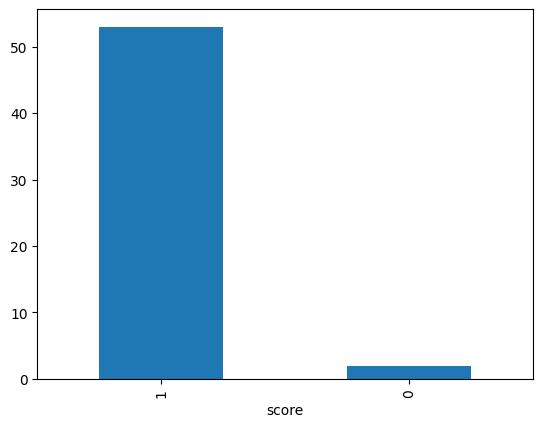

In [20]:
print(f"Total mean score: {eval_results.score.mean():.4f}")
print(f"Total median score: {eval_results.score.median():.4f}")

eval_results.score.value_counts().plot.bar()

In [67]:
tool_spans = px.Client().query_spans(
    SpanQuery()
    .where("span_kind == 'LLM'and status_code == 'OK' and 'final_answer' in llm.output_messages")
    .select(
        input="input.value",
        output="output.value",
    ),
    project_name="saiga-nemo-12b-Q4",
)
tool_spans.head()

,input,output
context.span_id,,
f759113e5a377adc,"{""messages"": [{""role"": ""system"", ""content"": [{...","{""role"": ""assistant"", ""content"": ""{\n \""name\..."
0c97b12113b6697a,"{""messages"": [{""role"": ""system"", ""content"": [{...","{""role"": ""assistant"", ""content"": ""{\n \""name\..."
658152697f4f1138,"{""messages"": [{""role"": ""system"", ""content"": [{...","{""role"": ""assistant"", ""content"": ""{\n\""name\"":..."
7405ef8dee9896a5,"{""messages"": [{""role"": ""system"", ""content"": [{...","{""role"": ""assistant"", ""content"": ""{\n\""name\"":..."
3191757b13dcfa3d,"{""messages"": [{""role"": ""system"", ""content"": [{...","{""role"": ""assistant"", ""content"": ""{\n \""name\..."


In [85]:
tool_spans["reference"] = tool_spans["input"].apply(
    lambda x: json.loads(x)["messages"][4]["content"][0]["text"] if len(json.loads(x)["messages"]) > 4 else None
)
tool_spans.dropna(inplace=True)

print(tool_spans.shape)
tool_spans.head()

(55, 3)


,input,output,reference
context.span_id,,,
f759113e5a377adc,"{""messages"": [{""role"": ""system"", ""content"": [{...","{""role"": ""assistant"", ""content"": ""{\n \""name\...",Observation:\nНайденные отзывы о местах:\n\n==...
0c97b12113b6697a,"{""messages"": [{""role"": ""system"", ""content"": [{...","{""role"": ""assistant"", ""content"": ""{\n \""name\...",Observation:\nНайденные отзывы о местах:\n\n==...
658152697f4f1138,"{""messages"": [{""role"": ""system"", ""content"": [{...","{""role"": ""assistant"", ""content"": ""{\n\""name\"":...",Observation:\nНайденные отзывы о местах:\n\n==...
7405ef8dee9896a5,"{""messages"": [{""role"": ""system"", ""content"": [{...","{""role"": ""assistant"", ""content"": ""{\n\""name\"":...",Observation:\nНайденные отзывы о местах:\n\n==...
3191757b13dcfa3d,"{""messages"": [{""role"": ""system"", ""content"": [{...","{""role"": ""assistant"", ""content"": ""{\n \""name\...",Observation:\nНайденные отзывы о местах:\n\n==...


In [86]:
hallucination_classifications = llm_classify(
    dataframe=tool_spans,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=eval_model,
    rails=list(HALLUCINATION_PROMPT_RAILS_MAP.values()),
    provide_explanation=True,  # optional to generate explanations for the value produced by the eval LLM
)

/var/folders/hy/9y5wfvks4m55vpklg49y7g0r0000gn/T/ipykernel_25832/3216851784.py:6: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  hallucination_classifications = llm_classify(


llm_classify |          | 0/55 (0.0%) | ⏳ 00:00<? | ?it/s

In [88]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="TravelReviewQueryTool Hallucinations", dataframe=hallucination_classifications)
)
hallucination_classifications.head()

,label,explanation,exceptions,execution_status,execution_seconds
context.span_id,,,,,
f759113e5a377adc,factual,The query asks for restaurant recommendations....,[],COMPLETED,2.072351
0c97b12113b6697a,factual,The query asks for cafe recommendations. The t...,[],COMPLETED,2.156076
658152697f4f1138,factual,The query asks for beauty salons. The tool cal...,[],COMPLETED,2.015645
7405ef8dee9896a5,factual,The query asks for recommendations for bars an...,[],COMPLETED,2.140397
3191757b13dcfa3d,factual,The query asks for recommendations for nail sa...,[],COMPLETED,2.292303


<Axes: xlabel='label'>

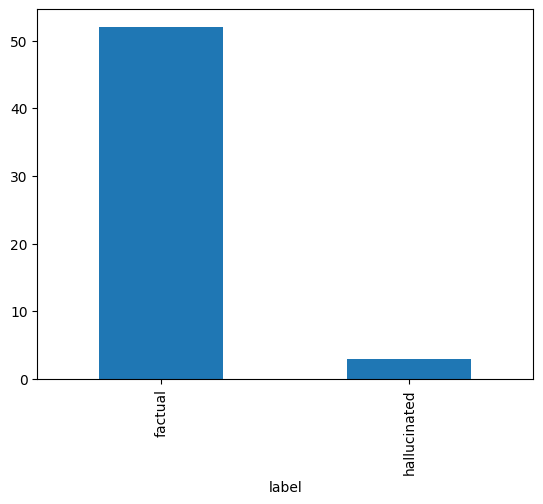

In [89]:
hallucination_classifications.label.value_counts().plot.bar()

In [96]:
hallucination_classifications[hallucination_classifications["label"] == "hallucinated"]

,label,explanation,exceptions,execution_status,execution_seconds
context.span_id,,,,,
2b963c689aa6eb46,hallucinated,The query asks for establishments at the addre...,[],COMPLETED,1.244691
41528e60aa4f6f0f,hallucinated,The query asks for establishments at the addre...,[],COMPLETED,1.125276
3ebdd7dd24e08fa9,hallucinated,"The query asks for places where ""huge gratitud...",[],COMPLETED,1.106687


## Single evaluation function

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
2025-05-01 20:30:11.056 | INFO     | travel_agent.retrieval.smolagents.tool:__init__:82 - Using device: mps


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: travel-agent-eval-hf.co/IlyaGusev/saiga_yandexgpt_8b_gguf:Q4_0-2025-05-01-19-58-36
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



llm_classify |          | 0/49 (0.0%) | ⏳ 00:00<? | ?it/s

Total mean score: 0.7959
Total median score: 1.0000
count    49.000000
mean      0.795918
std       0.407206
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: score, dtype: float64


<Axes: xlabel='score'>

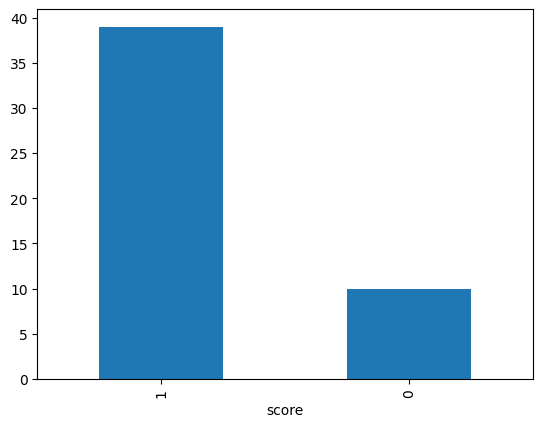

In [ ]:
questions = pd.read_csv("../data/questions/rag/moskva.csv")
llm_model_name = "hf.co/IlyaGusev/saiga_yandexgpt_8b_gguf:Q4_0"
embed_model_name = "intfloat/multilingual-e5-base"
collection_name = "moskva_intfloat_multilingual_e5_base"
# project_name = f"travel-agent-eval-{llm_model_name}"

tracer_provider = register(project_name=project_name, auto_instrument=True)
SmolagentsInstrumentor().instrument(tracer_provider=tracer_provider)

agent = ToolCallingAgent(
    tools=[TravelReviewQueryTool(embed_model_name, qdrant_client, collection_name)],
    model=LiteLLMModel(
        model_id=f"ollama_chat/{llm_model_name}",
        api_base=os.getenv("OLLAMA_URL", "http://127.0.0.1:11434"),
        num_ctx=8192,
    ),
    max_steps=10,
    verbosity_level=0,  # only errors
)

for q in tqdm(questions["question"].tolist()):
    agent.run(q)

tool_spans = (
    px.Client()
    .query_spans(
        SpanQuery().where("name == 'TravelReviewQueryTool'").select(input="input.value", reference="output.value"),
        project_name=project_name,
    )
    .dropna()
)
tool_spans["input"] = tool_spans["input"].apply(lambda x: json.loads(x).get("kwargs", {}).get("query", ""))

eval_results = llm_classify(
    data=tool_spans,
    model=GeminiModel(model="gemini-2.0-flash-lite-001", project=659002550737),
    template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    rails=["relevant", "unrelated"],
    concurrency=10,
    provide_explanation=True,
)
eval_results["score"] = eval_results["explanation"].apply(lambda x: 1 if "relevant" in x else 0)

px.Client().log_evaluations(SpanEvaluations(eval_name="TravelReviewQueryTool Relevancy", dataframe=eval_results))

print(f"Total mean score: {eval_results.score.mean():.4f}")
print(f"Total median score: {eval_results.score.median():.4f}")

print(eval_results.score.describe())

eval_results.score.value_counts().plot.bar()

/Users/damoiseev/personal/travel-agent/.venv/lib/python3.13/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (8.27.1) and client (8.31.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


Total mean score: 0.9333
Total median score: 1.0000
count    15.000000
mean      0.933333
std       0.258199
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: score, dtype: float64


<Axes: xlabel='score'>

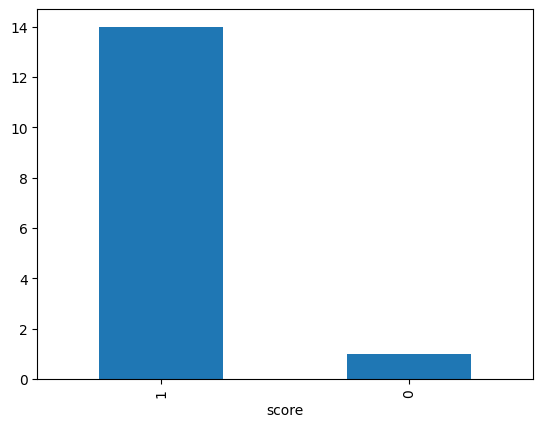

In [ ]:
questions = pd.read_csv("../data/questions/rag/moskva.csv")
llm_model_name = "meta-llama/Llama-3.3-70B-Instruct"
embed_model_name = "intfloat/multilingual-e5-base"
collection_name = "moskva_intfloat_multilingual_e5_base"
project_name = f"travel-agent-eval-{llm_model_name}"

tracer_provider = register(project_name=project_name, auto_instrument=True)
SmolagentsInstrumentor().instrument(tracer_provider=tracer_provider)

llm = InferenceClientModel(model_id=llm_model_name)

assert llm([{"role": "user", "content": [{"text": "Алло, это Кизару у телефона?", "type": "text"}]}]).content


agent = ToolCallingAgent(
    tools=[TravelReviewQueryTool(embed_model_name, qdrant_client, collection_name)],
    model=llm,
    max_steps=10,
    verbosity_level=0,  # only errors
)

for q in tqdm(questions["question"].tolist()):
    agent.run(q)

tool_spans = (
    px.Client()
    .query_spans(
        SpanQuery().where("name == 'TravelReviewQueryTool'").select(input="input.value", reference="output.value"),
        project_name=project_name,
    )
    .dropna()
)
tool_spans["input"] = tool_spans["input"].apply(lambda x: json.loads(x).get("kwargs", {}).get("query", ""))

assert len(tool_spans) > 0

eval_results = llm_classify(
    data=tool_spans,
    model=GeminiModel(model="gemini-2.0-flash-lite-001", project=659002550737),
    template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    rails=["relevant", "unrelated"],
    concurrency=10,
    provide_explanation=True,
)
eval_results["score"] = eval_results["explanation"].apply(lambda x: 1 if "relevant" in x else 0)

px.Client().log_evaluations(SpanEvaluations(eval_name="TravelReviewQueryTool Relevancy", dataframe=eval_results))

print(f"Total mean score: {eval_results.score.mean():.4f}")
print(f"Total median score: {eval_results.score.median():.4f}")

print(eval_results.score.describe())

eval_results.score.value_counts().plot.bar()

# Результат частичный, тк не хватило квоты на полный прогон